In [62]:
# nltk.download('stopwords')

In [63]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [64]:
# Gensim
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, Phrases
from gensim.models.phrases import Phraser
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [65]:
# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
from nltk.corpus import stopwords
from nltk import Tree

stop_words = stopwords.words('english')

In [67]:
df = pd.read_csv("usnewspaper_china.csv", header=None,)

In [68]:
data = df[0].dropna().tolist()

In [69]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
/var/folders/fd/qmhdtpdj7kj77ftrqfj87hmc0000gn/T/ipykernel_3918/2869499433.py:2: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


In [70]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
    
data_words = list(sent_to_words(data))

In [71]:
# Define functions for stopwords and lemmatization
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [72]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [73]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm')

In [74]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [75]:
data_lemmatized[2][:10]

['image',
 'make',
 'video',
 'chinese',
 'spokesperson',
 'gesture',
 'speak',
 'medium',
 'affair']

## Bigrams and Trigrams

In [76]:
bigram = Phrases(data_lemmatized, min_count=20, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[data_words], threshold=100)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [77]:
data_with_phrases = [trigram_mod[bigram_mod[doc]] for doc in data_words_nostops]

In [78]:
data_with_phrases[1][:10]

['cookie_preferences',
 'cookie_list',
 'cookie_list',
 'cookie',
 'small_piece',
 'data',
 'text_file',
 'website',
 'visited',
 'user_asks']

In [79]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
id2word.filter_extremes(no_below=20) # brings down unique tokens from 80 thousand to 12

# Create Corpus
texts = data_lemmatized#data_with_phrases

# Term Frequency list   
corpus = [id2word.doc2bow(text) for text in texts] 

In [80]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                id2word=id2word,
                num_topics=25, 
                random_state=100,
                update_every=1,
                chunksize=2000,
                passes=10,
                alpha='auto',
                eta='auto',
                per_word_topics=True)

In [81]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 6622
Number of documents: 10000


In [82]:
# Check the type of the numbers in the LDA topics
for topic in lda_model.print_topics():
    for word, prob in lda_model.show_topic(topic[0]):
        if isinstance(prob, complex):
            print(f"Complex number found in topic {topic[0]} for word '{word}'")

In [83]:
# Print the Keyword
#print(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [84]:
lda_model.print_topics()

[(2,
  '0.091*"que" + 0.041*"unido" + 0.041*"por" + 0.031*"estado" + 0.027*"este" + 0.022*"segun" + 0.022*"estadounidense" + 0.021*"paise" + 0.014*"millone" + 0.012*"puede"'),
 (12,
  '0.065*"die" + 0.053*"apple" + 0.031*"iphone" + 0.019*"und" + 0.016*"m" + 0.012*"sale" + 0.011*"fur" + 0.011*"report" + 0.009*"market" + 0.009*"auch"'),
 (6,
  '0.053*"space" + 0.022*"satellite" + 0.016*"mission" + 0.013*"station" + 0.012*"het" + 0.012*"launch" + 0.011*"meet" + 0.010*"moon" + 0.009*"rocket" + 0.009*"land"'),
 (7,
  '0.016*"population" + 0.013*"drug" + 0.012*"child" + 0.012*"charge" + 0.011*"information" + 0.011*"accord" + 0.011*"fentanyl" + 0.010*"officer" + 0.009*"agent" + 0.008*"federal"'),
 (0,
  '0.037*"import" + 0.034*"oil" + 0.024*"export" + 0.021*"price" + 0.017*"trade" + 0.014*"crude" + 0.014*"gas" + 0.014*"coal" + 0.012*"demand" + 0.010*"russian"'),
 (8,
  '0.032*"debt" + 0.029*"country" + 0.024*"loan" + 0.014*"pay" + 0.013*"bank" + 0.012*"government" + 0.011*"payment" + 0.010*"f

In [85]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [86]:
try:
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
except Exception as e:
    print(f"Error preparing LDA visualization: {e}")

In [87]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3      0.108184 -0.017204       1        1  9.660502
21     0.047705  0.083876       2        1  7.444416
24     0.127506 -0.001562       3        1  7.423293
9      0.121767 -0.101802       4        1  7.396106
20     0.104387  0.022050       5        1  7.370156
16    -0.079415  0.176945       6        1  6.480141
13     0.060322 -0.001308       7        1  5.709730
1      0.096334 -0.007954       8        1  5.140681
23     0.018594  0.061627       9        1  4.769924
5      0.060799 -0.034502      10        1  4.746893
4     -0.024272  0.090709      11        1  4.174388
14     0.025926 -0.128942      12        1  3.239363
17     0.084308 -0.050725      13        1  3.223445
19     0.035636 -0.071766      14        1  2.811002
22     0.025562 -0.033437      15        1  2.577153
10    -0.022547  0.104818      16        1  2.516776
15    -0.211891  0.153822      17        1  2.381737
8      0.011797  0.077690      18        1  2.318867
7      0.075380 -0.081652      19        1  1.921091
11     0.001888 -0.066430      20        1  1.810583
0     -0.132502  0.143840      21        1  1.706636
18     0.021974 -0.057622      22        1  1.678921
6      0.040109 -0.054655      23        1  1.331169
12    -0.217524  0.134515      24        1  1.253135
2     -0.380026 -0.340330      25        1  0.913892, topic_info=          Term         Freq        Total Category  logprob  loglift
1164   company  8838.000000  8838.000000  Default  30.0000  30.0000
1245   balloon  5271.000000  5271.000000  Default  29.0000  29.0000
204   military  8845.000000  8845.000000  Default  28.0000  28.0000
278      share  4303.000000  4303.000000  Default  27.0000  27.0000
522        que  1819.000000  1819.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
504    embargo   113.900276   146.529992  Topic25  -5.1621   4.4433
110        era   149.407485   638.156442  Topic25  -4.8908   3.2433
1046       com   152.404225   959.876492  Topic25  -4.8709   2.8549
517      jinpe   160.416385  1657.037008  Topic25  -4.8197   2.3602
503         do   114.967918   696.795023  Topic25  -5.1528   2.8934

[1755 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4099      1  0.980849  abduction
2619      8  0.983388   abortion
2717     10  0.971488    abreast
5969      1  0.966523    abstain
3281      3  0.956197   academia
...     ...       ...        ...
5760      1  0.046041        zoo
5760      8  0.024555        zoo
5760      9  0.923880        zoo
3970     20  0.985096     zookey
5369     24  0.997042         zu

[8919 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 22, 25, 10, 21, 17, 14, 2, 24, 6, 5, 15, 18, 20, 23, 11, 16, 9, 8, 12, 1, 19, 7, 13, 3])

In [88]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -7.239377250134306


In [89]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.49985656206738405


## Testing different number of topics for LDA

In [29]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=10, step=5):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = LdaModel(corpus=corpus,
                id2word=id2word,
                num_topics=num_topics, 
                random_state=100,
                update_every=1,
                chunksize=2000,
                passes=10,
                alpha='auto',
                eta='auto'
                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [30]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=18, limit=27, step=2)

18
20
22
24
26


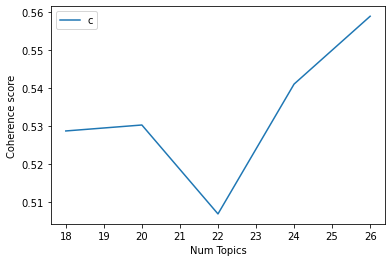

In [31]:
limit=27; start=18; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [32]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 18  has Coherence Value of 0.5287
Num Topics = 20  has Coherence Value of 0.5303
Num Topics = 22  has Coherence Value of 0.5069
Num Topics = 24  has Coherence Value of 0.5411
Num Topics = 26  has Coherence Value of 0.559


### The optimal number of topics was 25

In [33]:
from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))